--- Part 3: Loading and Reshaping Data ---
Data successfully reshaped into wide format with shape: (18, 57)

--- Part 4: Engineering 'Slope' Features ---
Successfully created 55 engineered features.
The engineered features DataFrame 'X_slopes' has been saved to 'slopes_features.xlsx'

--- Part 6: Comparing Raw Data Model vs. Engineered Slope Model ---

--- Final Model Performance Comparison ---
1. Raw Data Model:    Accuracy = 72.22% (± 7.86%)
2. Slope Feature Model: Accuracy = 94.44% (± 7.86%)

Conclusion: The Slope Model provides a significant improvement in accuracy.
All subsequent analysis will be performed using the superior Slope Model features.

--- Part 7: Detailed Evaluation of the Final Slope Model ---

Classification Report:
              precision    recall  f1-score   support

 M13+Staples       1.00      0.83      0.91         6
    Nanotube       1.00      1.00      1.00         6
    Triangle       0.86      1.00      0.92         6

    accuracy                        

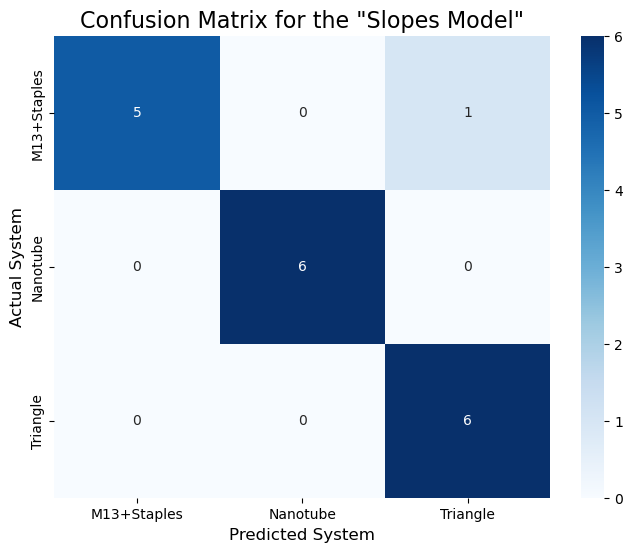

/var/folders/wt/zh3vhcgd1wj45dfnf7rdjbbc0000gn/T/ipykernel_5369/2231188200.py:218: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



--- 8.1: 2D PLS-DA with Confidence Ellipses ---


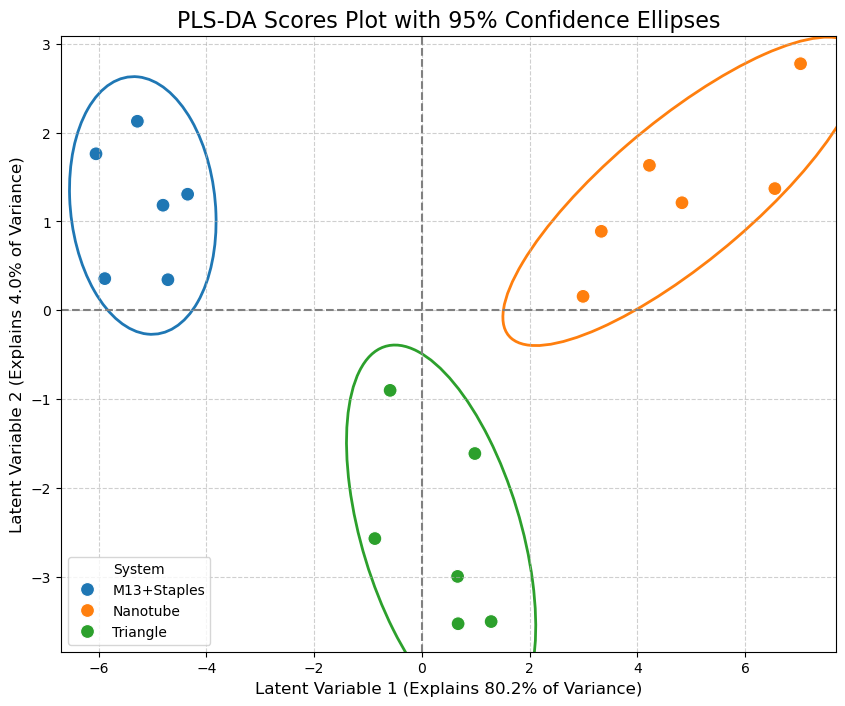


--- 8.2: 3D Interactive PLS-DA Plot ---



--- Analysis Complete ---


In [1]:
# =============================================================================
# --- Part 0: Header and Abstract ---
# =============================================================================
"""
# Machine Learning for DNA Origami Shape Discrimination

**Author:** Yigit
**Date:** September 2025

## Abstract
This script details the machine learning workflow used to classify three distinct
DNA origami nanostructures (`M13+Staples`, `Nanotube`, `Triangle`) based on their
dynamic fluorescence recovery profiles from an 11-nanosensor array. The core
of this analysis is a feature engineering strategy called the **"Slope Model"**,
which transforms raw time-series data into features representing the rate of
fluorescence change. The superiority of this approach over using raw data is
explicitly demonstrated. The engineered features are then used to train and
evaluate two complementary supervised learning models: **Random Forest (RF)** for
classification and **Partial Least Squares Discriminant Analysis (PLS-DA)**
for visualizing class separation.
"""

# =============================================================================
# --- Part 1: Setup and Library Imports ---
# =============================================================================

# --- Data and Math Libraries ---
import pandas as pd
import numpy as np

# --- Visualization Libraries ---
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import transforms
import plotly.express as px

# --- Scikit-Learn for Machine Learning ---
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import classification_report, confusion_matrix

# =============================================================================
# --- Part 2: Helper Functions ---
# =============================================================================

def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    Represents the 95% confidence interval by default (n_std=2.0).
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def calculate_explained_variance(model, X, y_encoded):
    """Calculate the variance explained by each individual PLS component."""
    total_variance = np.sum(np.var(X, axis=0))

    # Calculate cumulative variance for each number of components
    cumulative_var = []
    for i in range(1, model.n_components + 1):
        pls_model = PLSRegression(n_components=i)
        pls_model.fit(X, y_encoded)
        X_transformed = pls_model.transform(X)
        X_reconstructed = pls_model.inverse_transform(X_transformed)
        var_explained = 100 * (1 - np.sum(np.var(X - X_reconstructed, axis=0)) / total_variance)
        cumulative_var.append(var_explained)

    # Calculate individual component contributions
    component_var = [cumulative_var[0]]
    for i in range(1, len(cumulative_var)):
        component_var.append(cumulative_var[i] - cumulative_var[i - 1])

    return component_var

# =============================================================================
# --- Part 3: Data Loading and Preprocessing ---
# =============================================================================
print("--- Part 3: Loading and Reshaping Data ---")
df_long = pd.read_excel('Fluorescence_recovery_24-32_min_updated.xlsx', sheet_name='Combined data')
df_long.columns = df_long.columns.str.strip()

# Reshape from long to wide format, creating one row per experimental replicate
df_wide = df_long.pivot_table(
    index=['System', 'Replicate'],
    columns='Time',
    values=[col for col in df_long.columns if '-nGO' in col]
)
df_wide.columns = [f'{sensor}_{time}' for sensor, time in df_wide.columns]
df_wide = df_wide.reset_index()
print(f"Data successfully reshaped into wide format with shape: {df_wide.shape}\n")

# =============================================================================
# --- Part 4: Feature Engineering (The "Slope Model") ---
# =============================================================================
print("--- Part 4: Engineering 'Slope' Features ---")
# Initialize an empty DataFrame to hold the new dynamic features
X_slopes = pd.DataFrame()

# Get the base names of the 11 nanosensors
base_sensors = [col.replace('_24', '') for col in df_wide.columns if col.endswith('_24')]
base_sensors = [s for s in base_sensors if '-nGO' in s]

# Loop through each sensor to create its five dynamic features
for sensor in base_sensors:
    X_slopes[f'{sensor}_initial'] = df_wide[f'{sensor}_24']
    X_slopes[f'{sensor}_slope_24_26'] = df_wide[f'{sensor}_26'] - df_wide[f'{sensor}_24']
    X_slopes[f'{sensor}_slope_26_28'] = df_wide[f'{sensor}_28'] - df_wide[f'{sensor}_26']
    X_slopes[f'{sensor}_slope_28_30'] = df_wide[f'{sensor}_30'] - df_wide[f'{sensor}_28']
    X_slopes[f'{sensor}_slope_30_32'] = df_wide[f'{sensor}_32'] - df_wide[f'{sensor}_30']

print(f"Successfully created {X_slopes.shape[1]} engineered features.")
X_slopes.to_excel('slopes_features.xlsx', index=False)
print("The engineered features DataFrame 'X_slopes' has been saved to 'slopes_features.xlsx'\n")

# =============================================================================
# --- Part 5: Target Variable Preparation ---
# =============================================================================
y = df_wide['System']
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# =============================================================================
# --- Part 6: Model Comparison & Justification ---
# =============================================================================
print("--- Part 6: Comparing Raw Data Model vs. Engineered Slope Model ---")

# Define the two feature sets to be compared
X_raw = df_wide.drop(columns=['System', 'Replicate']) # 55 raw fluorescence values
# X_slopes is the DataFrame with 55 engineered features from Part 4

# Define the Random Forest models and the cross-validator
raw_model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
slopes_model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Evaluate both models using stratified cross-validation
scores_raw = cross_val_score(raw_model_rf, X_raw, y_encoded, cv=skf)
scores_slopes = cross_val_score(slopes_model_rf, X_slopes, y_encoded, cv=skf)

# Print the final performance comparison
print("\n--- Final Model Performance Comparison ---")
print(f"1. Raw Data Model:    Accuracy = {np.mean(scores_raw):.2%} (± {np.std(scores_raw):.2%})")
print(f"2. Slope Feature Model: Accuracy = {np.mean(scores_slopes):.2%} (± {np.std(scores_slopes):.2%})")
print("\nConclusion: The Slope Model provides a significant improvement in accuracy.")
print("All subsequent analysis will be performed using the superior Slope Model features.\n")


# =============================================================================
# --- Part 7: Detailed Performance of the Slope Model ---
# =============================================================================
print("--- Part 7: Detailed Evaluation of the Final Slope Model ---")

# Get fair predictions using the already defined slope model and CV splitter
cv_predictions = cross_val_predict(slopes_model_rf, X_slopes, y_encoded, cv=skf)

# Generate and print the detailed classification report
print("\nClassification Report:")
report = classification_report(y_encoded, cv_predictions, target_names=le.classes_)
print(report)

# Generate and plot the confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_encoded, cv_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for the \"Slopes Model\"', fontsize=16)
plt.ylabel('Actual System', fontsize=12)
plt.xlabel('Predicted System', fontsize=12)
plt.savefig('confusion_matrix.eps', format='eps', bbox_inches='tight')
plt.show()

# =============================================================================
# --- Part 8: PLS-DA Visualization of Class Separation ---
# =============================================================================

# --- 8.1: 2D PLS-DA with Confidence Ellipses ---
print("\n--- 8.1: 2D PLS-DA with Confidence Ellipses ---")
# Fit the PLS-DA model with 2 components for visualization
plsda_2d = PLSRegression(n_components=2)
plsda_2d.fit(X_slopes, y_encoded)

# Calculate explained variance for each of the 2 components
component_var_2d = calculate_explained_variance(plsda_2d, X_slopes, y_encoded)

# Get the scores (projections onto the latent variables)
scores_2d = plsda_2d.transform(X_slopes)
scores_df_2d = pd.DataFrame(data=scores_2d, columns=['Latent Variable 1', 'Latent Variable 2'])
scores_df_2d['System'] = y

# Create the plot with the 95% confidence ellipses
fig, ax = plt.subplots(figsize=(10, 8))
palette = sns.color_palette()
sns.scatterplot(
    data=scores_df_2d, x='Latent Variable 1', y='Latent Variable 2', hue='System',
    palette=palette, s=100, ax=ax
)

# Add an ellipse for each group
for i, system in enumerate(scores_df_2d['System'].unique()):
    group_data = scores_df_2d[scores_df_2d['System'] == system]
    confidence_ellipse(
        group_data['Latent Variable 1'], group_data['Latent Variable 2'], ax,
        n_std=2, edgecolor=palette[i], linewidth=2
    )

ax.set_title('PLS-DA Scores Plot with 95% Confidence Ellipses', fontsize=16)
ax.set_xlabel(f'Latent Variable 1 (Explains {component_var_2d[0]:.1f}% of Variance)', fontsize=12)
ax.set_ylabel(f'Latent Variable 2 (Explains {component_var_2d[1]:.1f}% of Variance)', fontsize=12)
ax.axhline(0, color='grey', linestyle='--')
ax.axvline(0, color='grey', linestyle='--')
ax.grid(True, linestyle='--', alpha=0.6)
plt.savefig('plsda_2d.eps', format='eps', bbox_inches='tight')
plt.show()

# --- 8.2: 3D Interactive PLS-DA Plot ---
print("\n--- 8.2: 3D Interactive PLS-DA Plot ---")
# Fit the PLS-DA model with 3 components
plsda_3d = PLSRegression(n_components=3).fit(X_slopes, y_encoded)
scores_3d = plsda_3d.transform(X_slopes)
scores_df_3d = pd.DataFrame(data=scores_3d, columns=['LV1', 'LV2', 'LV3'])
scores_df_3d['System'] = y

# Calculate explained variance for the 3 components
component_var_3d = calculate_explained_variance(plsda_3d, X_slopes, y_encoded)

# Create the interactive 3D plot using Plotly Express
fig_3d = px.scatter_3d(
    scores_df_3d,
    x='LV1', y='LV2', z='LV3',
    color='System',
    title='Interactive 3D PLS-DA Scores Plot',
    labels={
        'LV1': f'Latent Variable 1 ({component_var_3d[0]:.1f}%)',
        'LV2': f'Latent Variable 2 ({component_var_3d[1]:.1f}%)',
        'LV3': f'Latent Variable 3 ({component_var_3d[2]:.1f}%)'
    }
)
fig_3d.update_traces(marker=dict(size=6, opacity=0.8))
fig_3d.show()

# =============================================================================
# --- Part 9: Analysis Complete ---
# =============================================================================
print("\n--- Analysis Complete ---")